# Convolutional Neural Network

We'll use the MNIST data set to test three convolutional neural networks, made with:
1. Tensorflow
2. Keras Sequential Model
3. Keras Functional API

## MNIST data

Prepare the data:

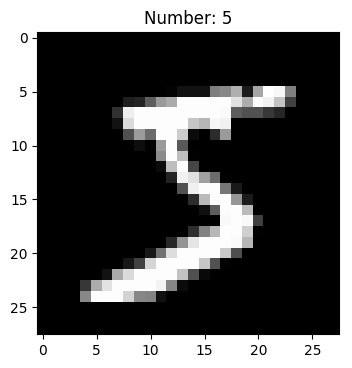

In [1]:
import tensorflow as tf
import numpy as np
mnist = tf.keras.datasets.mnist

(mnist_X_train, mnist_y_train),(mnist_X_test, mnist_y_test) = mnist.load_data()

# Normalize and reshape images to [28,28,1]
mnist_X_train  = np.expand_dims(mnist_X_train.astype(np.float32) / 255.0, axis=3)
mnist_X_test = np.expand_dims(mnist_X_test.astype(np.float32) / 255.0, axis=3)

# View a sample image
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(dpi=100)
plt.imshow(np.squeeze(mnist_X_train[0]), cmap='gray')
plt.title('Number: {}'.format(str(mnist_y_train[0])))
plt.show()


The labels are numbers, so we need to convert to one-hot encoding.

In [2]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False, dtype=np.float32)
mnist_y_train = enc.fit_transform(mnist_y_train.reshape(-1,1), y=range(10))
mnist_y_test = enc.fit_transform(mnist_y_test.reshape(-1,1), y=range(10))


## Tensorflow

First, we'll create a CNN without keras.

Let's start a tensorflow [session](https://www.tensorflow.org/api_docs/python/tf/Session).

`A Session object encapsulates the environment in which Operation objects are executed, and Tensor objects are evaluated.`  Trained models need to be saved before closing a session.




In [3]:
sess = tf.Session()

### Data Iterator

We can create an iterator that returns batches of images and ground truths from the MNIST data.

In [4]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((mnist_X_train,mnist_y_train)).repeat().batch(batch_size)
iterator = dataset.make_initializable_iterator()
data_batch = iterator.get_next()
sess.run(iterator.initializer)

batch_images, batch_labels = sess.run(data_batch)

print(batch_images.shape)

(128, 28, 28, 1)


### Convolution

Here we'll create a function to do a 2D convolution.

A single layer follows the function $W*x+b$ where $x$ is the input to the layer, $W$ are the filter weights, and $b$ is the bias.  The convolution $W*x$ can be done with [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) and the addition of the bias can be done with [tf.nn.bias_add](https://www.tensorflow.org/api_docs/python/tf/nn/bias_add) or [tf.add](https://www.tensorflow.org/api_docs/python/tf/math/add).

We'll also use [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu) for the activation function in each layer. 


In [5]:
#Define 2D convolutional function
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


### Weights

Next, we can initialize the weights for the layers in a dictionary by using [tf.get_variable](https://www.tensorflow.org/api_docs/python/tf/get_variable).  Looking at the doc for [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d), each filter has the shape `[filter_height, filter_width, in_channels, out_channels]`.  

The weights are initialized with [tf.contrib.layers.xavier_initializer](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer) from [Xavier Glorot and Yoshua Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

`This initializer is designed to keep the scale of the gradients roughly the same in all layers.`

In [6]:
n_classes = 10

#Define Weights
weights = {
    # Convolution Layers
    'c1': tf.get_variable('W0', shape=(3,3,1,16), initializer=tf.contrib.layers.xavier_initializer()), 
    'c2': tf.get_variable('W1', shape=(3,3,16,16), initializer=tf.contrib.layers.xavier_initializer()),
    'c3': tf.get_variable('W2', shape=(3,3,16,32), initializer=tf.contrib.layers.xavier_initializer()),
    'c4': tf.get_variable('W3', shape=(3,3,32,32), initializer=tf.contrib.layers.xavier_initializer()),
    
    # Dense Layers
    'd1': tf.get_variable('W4', shape=(2*2*32,16), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W6', shape=(16,n_classes), initializer=tf.contrib.layers.xavier_initializer()),
}

biases = {
    # Convolution Layers
    'c1': tf.get_variable('B0', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'c2': tf.get_variable('B1', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'c3': tf.get_variable('B2', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'c4': tf.get_variable('B3', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    
    # Dense Layers
    'd1': tf.get_variable('B4', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B5', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer()),
}

### Model
Next we can create the model using these weights.  Each layer has the tensor shape shown.

After each convolution layer, we can add a [max pooling layer](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool).  `ksize` is the kernel size of the max pool and `strides` is the stride of the sliding window.  Since the stride size across the image is 2, the dimension is reduced by half.  For odd input sizes, the output shape is determined by the ceiling after dividing by 2 (e.g. 7/2 = 4).

After the fourth convolution layer, the tensor is [reshaped](https://www.tensorflow.org/api_docs/python/tf/reshape) so it is flattened by before a fully connected layer.  The weights for the fully connected layer are not a convolution, but rather a [matrix multiplication](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul).

A [dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) is added, where the probability of keeping a weight is given.

The output layer is another fully connected layer.  The activation for the output layer is not given yet.

In [7]:
def conv_net(data, weights, biases):
    # Convolution layers
    conv1 = conv2d(data, weights['c1'], biases['c1']) # [28,28,16]
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [14,14,16]

    conv2 = conv2d(conv1, weights['c2'], biases['c2']) # [14,14,16]
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [7,7,16]

    conv3 = conv2d(conv2, weights['c3'], biases['c3']) # [7,7,32]
    conv3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [4,4,32]

    conv4 = conv2d(conv3, weights['c4'], biases['c4']) # [4,4,32]
    conv4 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [2,2,32]

    # Flatten
    flat = tf.reshape(conv4, [-1, weights['d1'].get_shape().as_list()[0]]) # [2*2*32] = [128]

    # Fully connected layer
    fc1 = tf.add(tf.matmul(flat, weights['d1']), biases['d1']) # [16]
    fc1 = tf.nn.relu(fc1) # [16]

    # Dropout
    keep_prob = 0.8
    do1 = tf.nn.dropout(fc1, keep_prob)

    # Output
    out = tf.add(tf.matmul(do1, weights['out']), biases['out']) # [10]
    return out


### Computational Graph

Next we can construct a computational graph that will be used for training.  The graph determines how functions will interact in a session.

Here we will initialize a model to be trained.  We can create a [placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for the training data that can be replaced with batches of data.  The shape of the placeholder is `[batch size, height, width, channels]`.  Having `None` as the shape for any dimension allows it to be variable.  Since the MNIST images are grayscale, they are single-channel.

In [8]:
Xtrain = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
logits = conv_net(Xtrain, weights, biases)

#### Loss

[tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean) measures the mean of the elements in the tensor.  We can use it to find the mean [cross entropy of the logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) from our model compared to the ground truth.  Our ground truth again depends on the batch, so we need a placeholder.

In [9]:
ytrain = tf.placeholder(tf.float32, shape=(None, n_classes))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=ytrain))

#### Optimizer

Using the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) to minimize the loss.

In [10]:
optimizer = tf.train.AdamOptimizer(1e-4)

#### Training operation

The training is done by using the optimizer to minimize the loss.

In [11]:
train_op = optimizer.minimize(loss)

#### Accuracy

After each epoch, we can check the model accuracy by checking the percent correct predictions on the test set.  The predictions can be found by using the [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) of the model output.  The predictions are one-hot encoded, so they need to be converted to the number labels by [argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax).

The two outputs of [accuracy](https://www.tensorflow.org/api_docs/python/tf/metrics/accuracy):

- `accuracy`: A Tensor representing the accuracy, the value of total divided by count.
- `update_op`: An operation that increments the total and count variables appropriately and whose value matches accuracy

In [12]:
test_predictions = tf.nn.softmax(conv_net(mnist_X_test, weights, biases))
acc,acc_op = tf.metrics.accuracy(predictions=tf.argmax(test_predictions,1), labels=tf.argmax(mnist_y_test,1))

### Training

#### Local and Global Variables
The [local](https://www.tensorflow.org/api_docs/python/tf/initializers/local_variables) and [global](https://www.tensorflow.org/api_docs/python/tf/initializers/global_variables) variables created are first initialized so they can be used in the session.


In [13]:
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())


#### Optimization

For each batch, a new set of images `batch_data` and ground truths `batch_labels` are retrieved.  A dictinoary `feed_dict` is used to feed them into the placeholders `Xtrain` and `ytrain`, which are then used in the graph using `sess.run`.  By calling the `optimizer` in the `sess.run`, all steps used to make the graph up to it are ran as given above.

#### Validation Accuracy

The accuracy can be measured after each training epoch by running a session with `acc_op`.  

In [14]:
from tqdm import tqdm
nepochs = 10
    
for epoch in range(nepochs):
    for step in tqdm(range(int(len(mnist_X_train)/batch_size))):
        
        # Batched data
        batch_images, batch_labels = sess.run(data_batch)

        # Train model
        feed_dict = {Xtrain: batch_images, ytrain: batch_labels}
        sess.run(train_op, feed_dict=feed_dict)

    # Test model
    accuracy = sess.run(acc_op)
    
    print('\nEpoch {} Accuracy: {}'.format(epoch+1, accuracy))


  0%|          | 2/468 [00:00<00:25, 18.29it/s]


Epoch 1 Accuracy: 0.575900018215


  0%|          | 2/468 [00:00<00:23, 19.55it/s]


Epoch 2 Accuracy: 0.660950005054


  0%|          | 2/468 [00:00<00:25, 18.11it/s]


Epoch 3 Accuracy: 0.712266683578


  0%|          | 2/468 [00:00<00:26, 17.85it/s]


Epoch 4 Accuracy: 0.744799971581


  0%|          | 2/468 [00:00<00:24, 19.09it/s]


Epoch 5 Accuracy: 0.767319977283


  0%|          | 2/468 [00:00<00:25, 18.48it/s]


Epoch 6 Accuracy: 0.78558331728


  0%|          | 2/468 [00:00<00:25, 18.44it/s]


Epoch 7 Accuracy: 0.799928545952


  0%|          | 2/468 [00:00<00:24, 19.31it/s]


Epoch 8 Accuracy: 0.810887515545


  0%|          | 2/468 [00:00<00:30, 15.48it/s]


Epoch 9 Accuracy: 0.820200026035


100%|██████████| 468/468 [00:20<00:00, 23.13it/s]



Epoch 10 Accuracy: 0.828469991684


The train images were created this way to illustrate using `sess.run` and `feed_dict` . However, this could have been done more concisely by having the data generator as part of the graph, like shown here.

In [15]:
batch_images, batch_labels = iterator.get_next()
logits = conv_net(batch_images, weights, biases)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=batch_labels))
train_op = optimizer.minimize(loss)

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

for epoch in range(nepochs):
    for step in tqdm(range(int(len(mnist_X_train)/batch_size))):
        
        # Train model
        sess.run(train_op)

    # Test model
    accuracy = sess.run(acc_op)
    
    print('\nEpoch {} Accuracy: {}'.format(epoch+1, accuracy))


  1%|          | 3/468 [00:00<00:21, 21.42it/s]


Epoch 1 Accuracy: 0.457399994135


  0%|          | 2/468 [00:00<00:24, 19.36it/s]


Epoch 2 Accuracy: 0.576250016689


  0%|          | 2/468 [00:00<00:24, 18.91it/s]


Epoch 3 Accuracy: 0.63913333416


  0%|          | 2/468 [00:00<00:26, 17.35it/s]


Epoch 4 Accuracy: 0.678699970245


  0%|          | 2/468 [00:00<00:24, 19.03it/s]


Epoch 5 Accuracy: 0.705340027809


  1%|          | 3/468 [00:00<00:21, 22.01it/s]


Epoch 6 Accuracy: 0.725533306599


  0%|          | 2/468 [00:00<00:24, 18.67it/s]


Epoch 7 Accuracy: 0.74067145586


  0%|          | 2/468 [00:00<00:24, 18.89it/s]


Epoch 8 Accuracy: 0.753087520599


  0%|          | 2/468 [00:00<00:25, 18.50it/s]


Epoch 9 Accuracy: 0.764077782631


100%|██████████| 468/468 [00:20<00:00, 22.79it/s]



Epoch 10 Accuracy: 0.774360001087


#### Closing a Session

The trained model needs to be [saved](https://www.tensorflow.org/api_docs/python/tf/train/Saver) before closing a session, or the model will be lost.

In [16]:
saver = tf.train.Saver() 
saver.save(sess, './filename.ckpt')

sess.close()

#### Restoring a Model

The model can be restored from the checkpoint by using a saver again.

In [17]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, 'filename.ckpt')


INFO:tensorflow:Restoring parameters from filename.ckpt


### Predictions

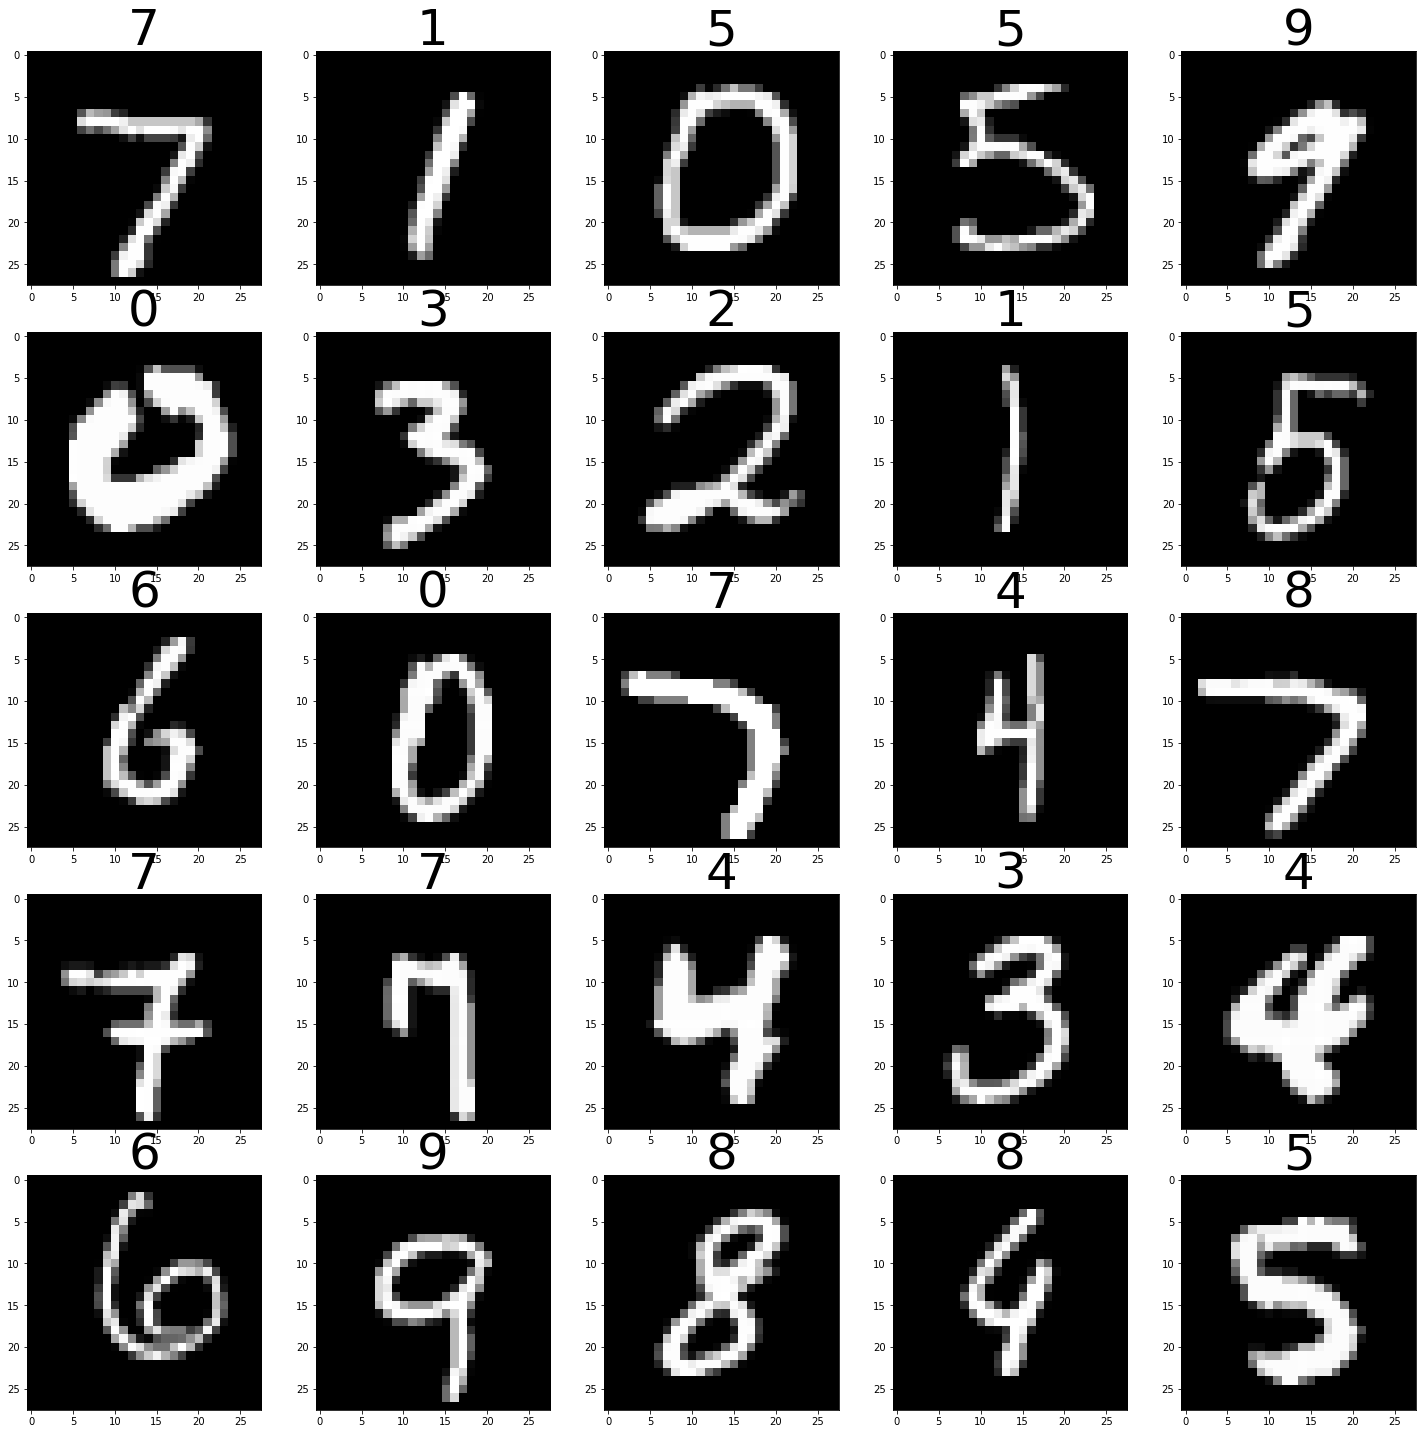

In [18]:
onehot_predictions = sess.run(test_predictions)
predictions = np.argmax(np.squeeze(onehot_predictions), axis=1)

idx = 0
f, axarr = plt.subplots(5, 5, figsize=(25,25))

for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(np.squeeze(mnist_X_test[idx]), cmap='gray')
        axarr[i,j].set_title(str(predictions[idx]),fontsize=50)
        idx += 5


In [19]:
sess.close()

## Keras

[Keras](https://keras.io/) can be used to develop models faster.  It's a higher-level implementation of tensorflow that allows for more compact code.

Imports we'll use:

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.optimizers import Adam


Using TensorFlow backend.


## Sequential Model

The first implementation of keras is with a [sequential model](https://keras.io/getting-started/sequential-model-guide/), which is only for linear stacks like the model we developed above.  Note that a tensorflow session is not needed.

### Model


In [21]:
model = Sequential()

Layers can be added by calling `add`.  The following will create the same model as the tensorflow model above.  Note that the input to the Dropout layer is the drop probability (above, it was the keep probability).

In [22]:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

optimizer = Adam(lr=1e-4)

After the model is designed, it is then [compiled](https://keras.io/getting-started/sequential-model-guide/#compilation).

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

The shapes of the weights in the layers are automatically calculated.  The CNN architecture can be viewed by calling a `summary`.

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 32)          9248      
__________

Now the model can be [fit](https://keras.io/models/model/#fit).

In [25]:
model.fit(mnist_X_train, mnist_y_train,
          epochs=nepochs,
          batch_size=batch_size,
        validation_data=(mnist_X_test, mnist_y_test),
          )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s 295us/step - loss: 1.6928 - acc: 0.4460 - val_loss: 0.6917 - val_acc: 0.8323
Epoch 2/10
60000/60000 [==============================] - 16s 260us/step - loss: 0.6674 - acc: 0.7890 - val_loss: 0.3097 - val_acc: 0.9184
Epoch 3/10
60000/60000 [==============================] - 16s 259us/step - loss: 0.4321 - acc: 0.8650 - val_loss: 0.2128 - val_acc: 0.9426
Epoch 4/10
60000/60000 [==============================] - 15s 253us/step - loss: 0.3443 - acc: 0.8944 - val_loss: 0.1710 - val_acc: 0.9507
Epoch 5/10
60000/60000 [==============================] - 15s 257us/step - loss: 0.2905 - acc: 0.9119 - val_loss: 0.1467 - val_acc: 0.9577
Epoch 6/10
60000/60000 [==============================] - 15s 257us/step - loss: 0.2566 - acc: 0.9226 - val_loss: 0.1271 - val_acc: 0.9638
Epoch 7/10
60000/60000 [==============================] - 16s 274us/step - loss: 0.2310 - acc: 0.9310 - val_loss: 0.

Finally, predictions can be shown.

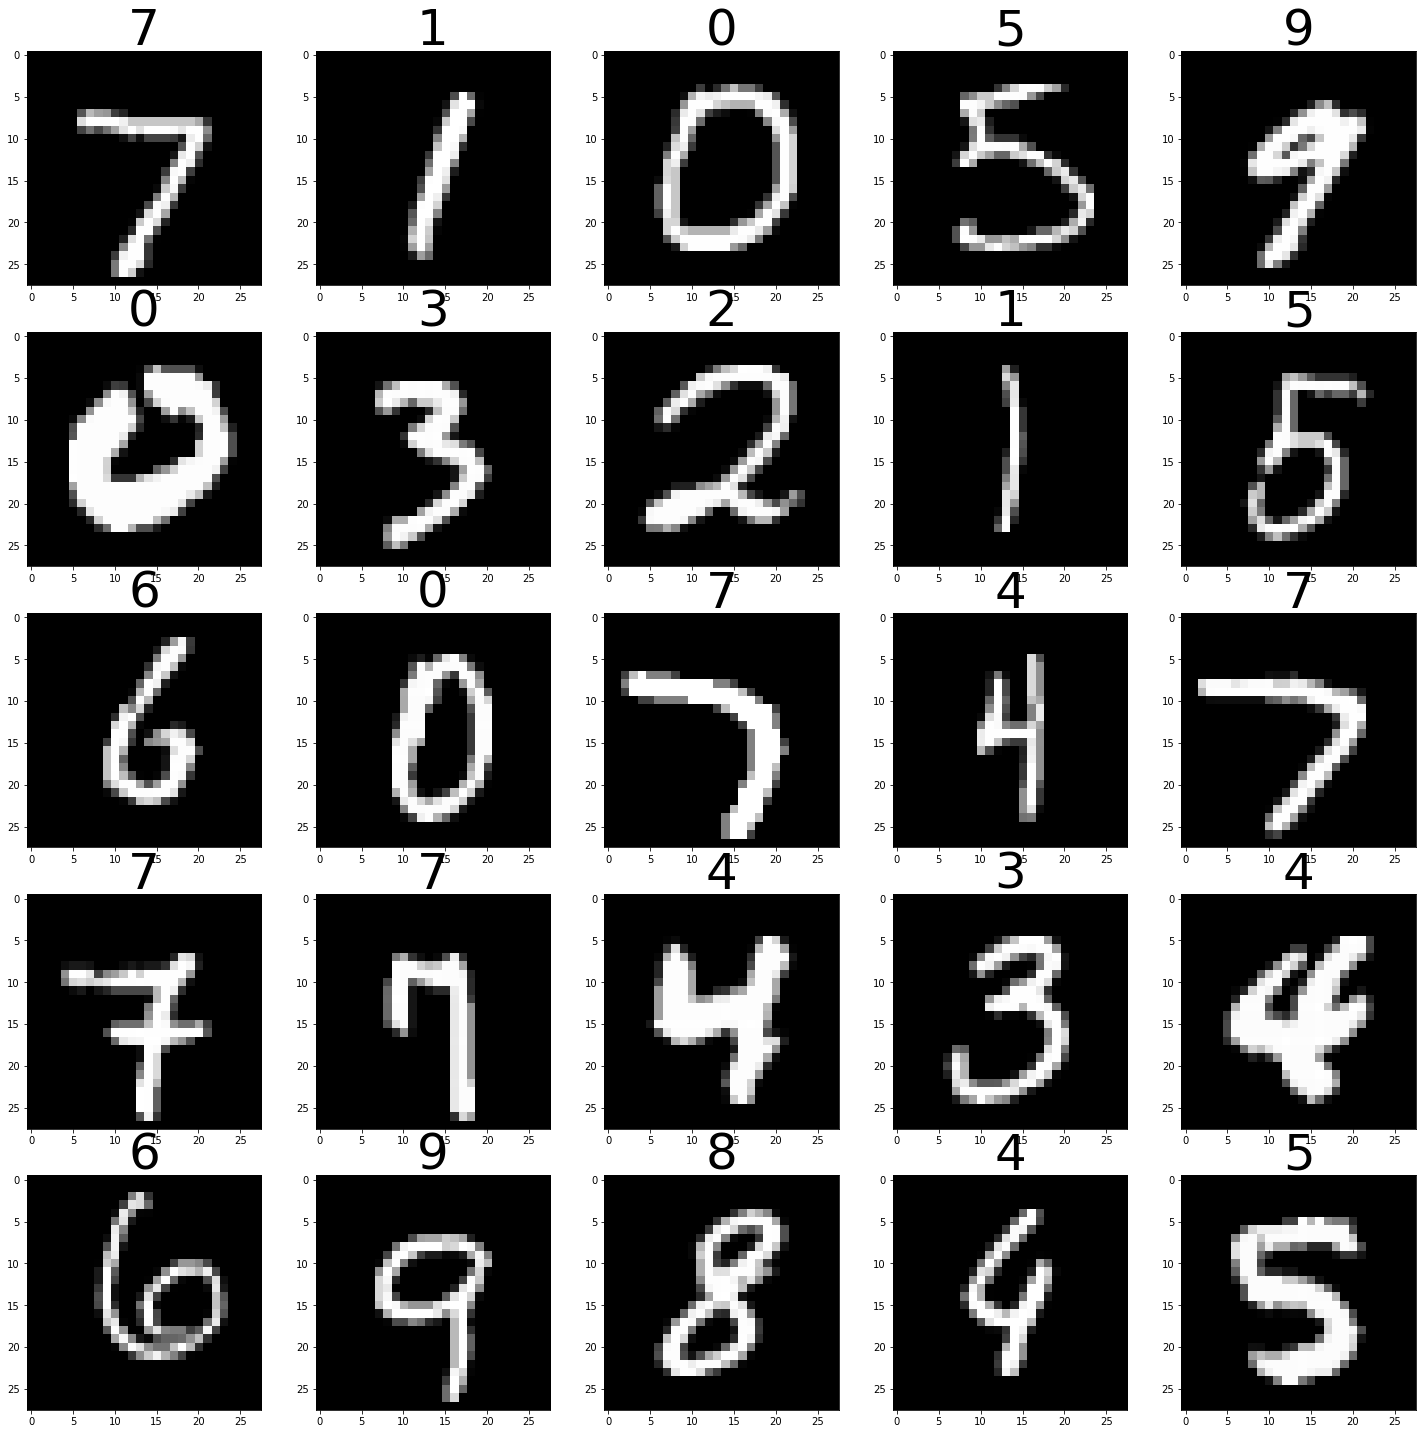

In [26]:
predictions = model.predict(mnist_X_test, batch_size=None, verbose=0, steps=None)
predictions = np.argmax(predictions, axis=1)

idx = 0
f, axarr = plt.subplots(5, 5, figsize=(25,25))

for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(np.squeeze(mnist_X_test[idx]), cmap='gray')
        axarr[i,j].set_title(str(predictions[idx]),fontsize=50)
        idx += 5


## Functional API

The [Keras Functional API](https://keras.io/getting-started/functional-api-guide/) allows for complex models with features such as multi-input/output and shared layers.

Instead of adding layers, layers are used as input to proceeding layers.

In [27]:
inputs = Input(shape=(28,28,1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(n_classes, activation='softmax')(x)

optimizer = Adam(lr=1e-4)


Once the architecture is designed, the input and output layers are used to make a [Model object](https://keras.io/models/model/).

In [28]:
model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


model.fit(mnist_X_train, mnist_y_train,
          epochs=nepochs,
          batch_size=batch_size,
          validation_data=(mnist_X_test, mnist_y_test),
          )


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 290us/step - loss: 1.7697 - acc: 0.4034 - val_loss: 0.8464 - val_acc: 0.8156
Epoch 2/10
60000/60000 [==============================] - 16s 261us/step - loss: 0.7841 - acc: 0.7503 - val_loss: 0.3476 - val_acc: 0.9223
Epoch 3/10
60000/60000 [==============================] - 17s 283us/step - loss: 0.5398 - acc: 0.8247 - val_loss: 0.2389 - val_acc: 0.9395
Epoch 4/10
60000/60000 [==============================] - 18s 292us/step - loss: 0.4509 - acc: 0.8562 - val_loss: 0.1931 - val_acc: 0.9488
Epoch 5/10
60000/60000 [==============================] - 17s 283us/step - loss: 0.3974 - acc: 0.8740 - val_loss: 0.1612 - val_acc: 0.9560
Epoch 6/10
60000/60000 [==============================] - 16s 265us/step - loss: 0.3581 - acc: 0.8900 - val_loss: 0.1456 - val_acc: 0.9599
Epoch 7/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.3335 - acc: 0.8954 - val_loss: 0.

Predictions:

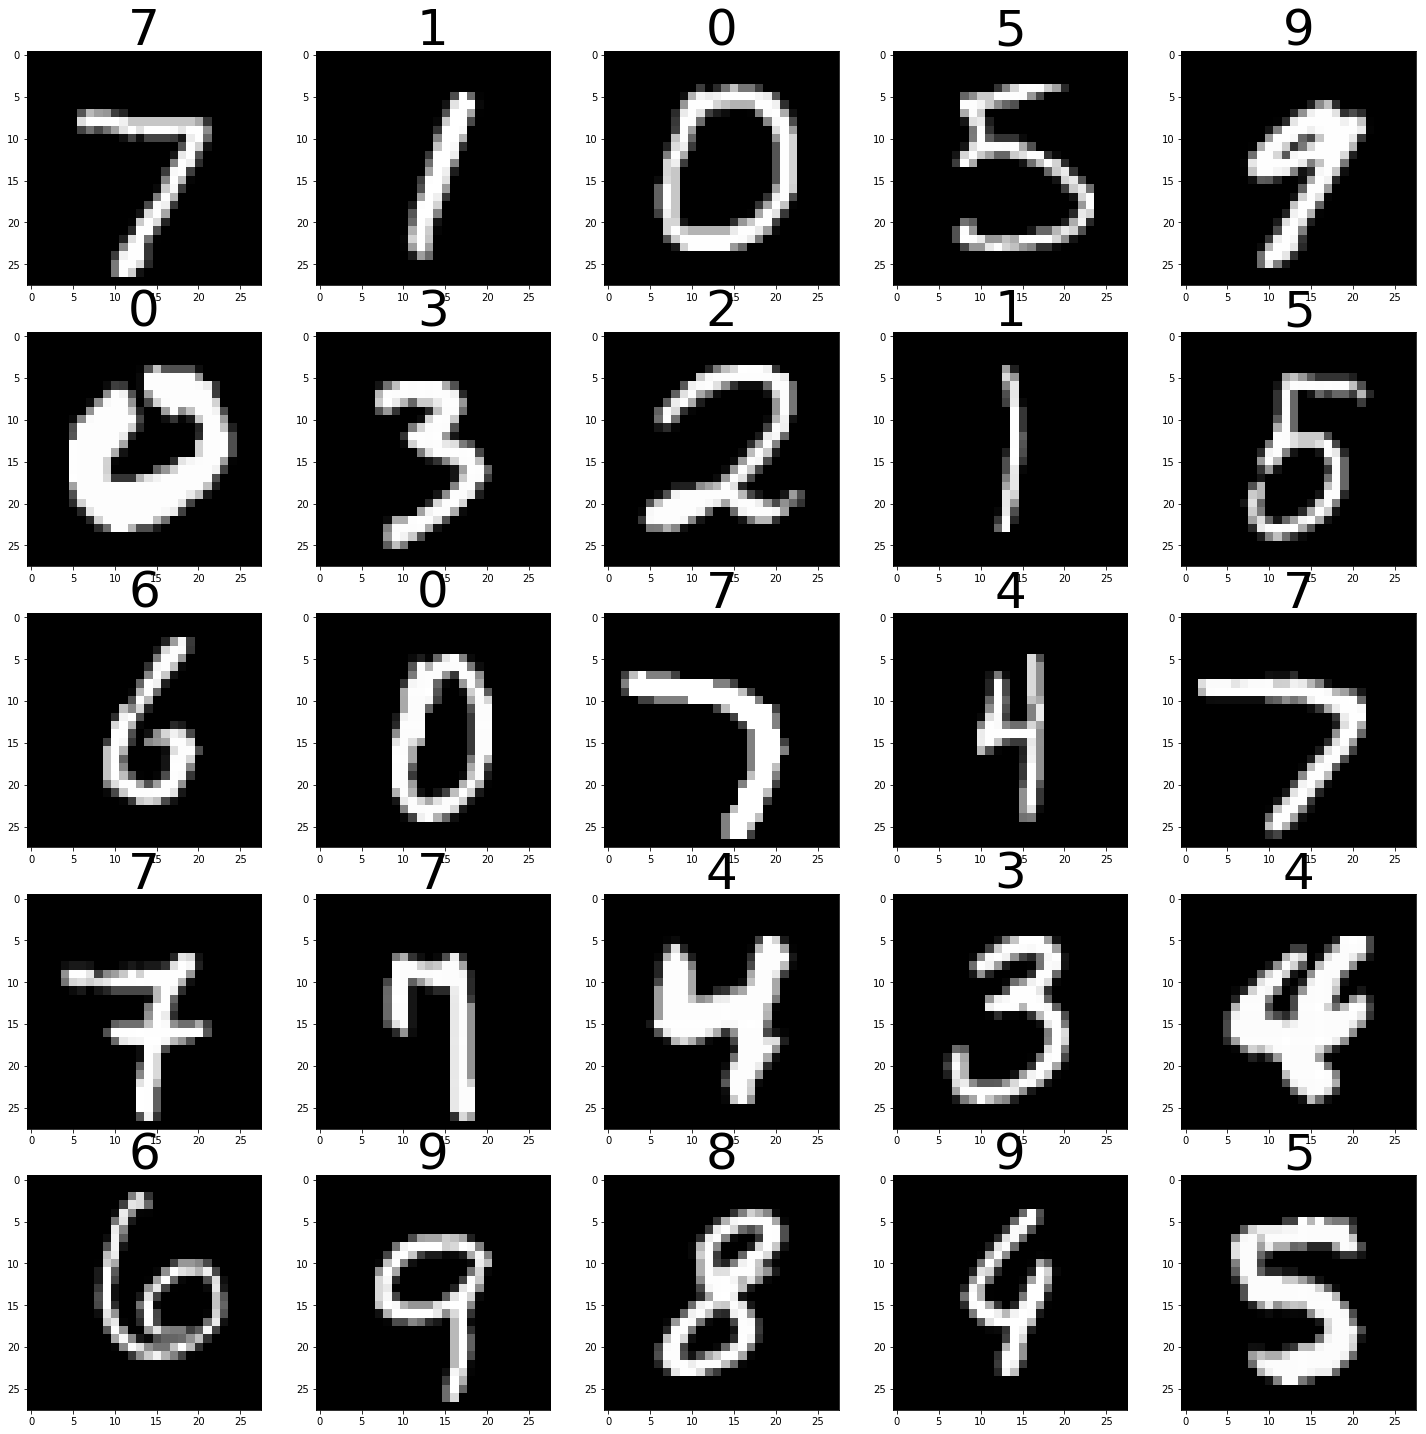

In [29]:
predictions = model.predict(mnist_X_test, batch_size=None, verbose=0, steps=None)
predictions = np.argmax(predictions, axis=1)


idx = 0
f, axarr = plt.subplots(5, 5, figsize=(25,25))

for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(np.squeeze(mnist_X_test[idx]), cmap='gray')
        axarr[i,j].set_title(str(predictions[idx]),fontsize=50)
        idx += 5
